In [1]:
from non_local_detector.simulate.sorted_spikes_simulation import make_simulated_data

(
    speed,
    position,
    spike_times,
    time,
    event_times,
    sampling_frequency,
    is_event,
    place_fields,
) = make_simulated_data(n_neurons=30)

/Users/edeno/miniconda3/envs/non_local_detector2/lib/python3.12/site-packages/non_local_detector/likelihoods/clusterless_kde.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [194]:
from non_local_detector.environment import Environment

env = Environment(place_bin_size=1.0).fit_place_grid(position[:, None])
env

Environment(environment_name='', place_bin_size=1.0, track_graph=None, edge_order=None, edge_spacing=None, is_track_interior=None, position_range=None, infer_track_interior=True, fill_holes=False, dilate=False, bin_count_threshold=0)

/var/folders/86/m147b4k17lddvs_xsw0mj2zw0000gn/T/ipykernel_77237/343177436.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  continuous_transition_matrix[0, 0] = Discrete().make_state_transition()


Text(0.5, 1.0, 'Continuous Transition Matrix')

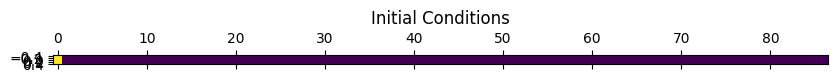

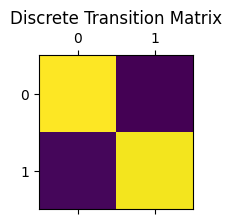

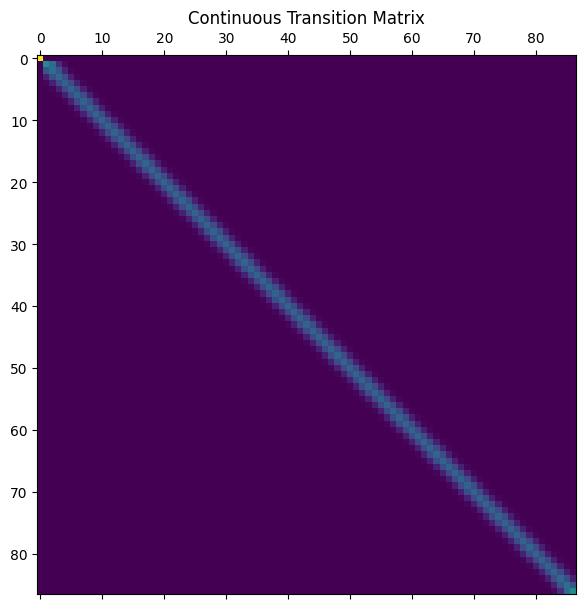

In [301]:
import numpy as np
import matplotlib.pyplot as plt
from non_local_detector.continuous_state_transitions import (
    RandomWalk,
    Discrete,
    Uniform,
)


n_position_bins = env.place_bin_centers_.shape[0]
initial_conditions = np.zeros((n_position_bins + 1,))

# State 1 is local - start in local state
# initial_conditions[1:] are the non-local state initial conditions
initial_conditions[0] = 1.0

# Local -> Local, Local -> Non-Local, Non-Local -> Local, Non-Local -> Non-Local
discrete_transition_matrix = np.array(
    [
        [0.999, 1 - 0.999],
        [0.02, 0.98],
    ]
)

continuous_transition_matrix = np.zeros((n_position_bins + 1, n_position_bins + 1))
continuous_transition_matrix[0, 0] = Discrete().make_state_transition()
continuous_transition_matrix[1:, 1:] = RandomWalk().make_state_transition(
    environments=[env]
)

state_ind = np.zeros((n_position_bins + 1,), dtype=int)
state_ind[1:] = 1
transition_matrix = (
    continuous_transition_matrix
    * discrete_transition_matrix[np.ix_(state_ind, state_ind)]
)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.matshow(initial_conditions[:, None].T)
ax.set_title("Initial Conditions")

fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.matshow(discrete_transition_matrix)
ax.set_title("Discrete Transition Matrix")

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.matshow(continuous_transition_matrix)
ax.set_title("Continuous Transition Matrix")

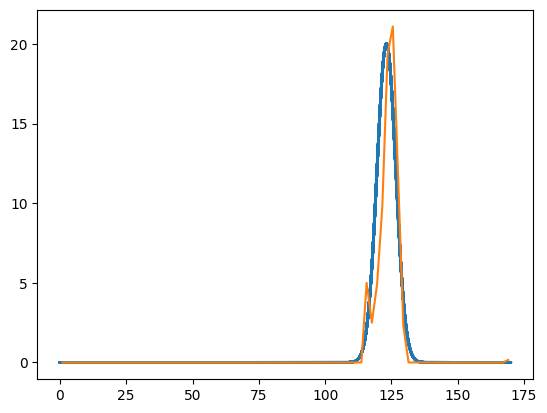

In [319]:
from non_local_detector.likelihoods.common import get_spikecount_per_time_bin
import jax.numpy as jnp
import jax.scipy.stats

spike_counts = np.stack(
    [get_spikecount_per_time_bin(times, time) for times in spike_times], axis=1
)

position_index = np.digitize(position, env.place_bin_edges_[:, 0][1:-1])

weights = np.ones_like(time)

occupancy_count = np.bincount(
    position_index, minlength=n_position_bins, weights=weights
)


def estimate_place_fields(spike_counts, position_index, occupancy_count, weights=None):
    if weights is None:
        weights = np.ones_like(position_index)
    estimated_place_fields = []
    n_position_bins = occupancy_count.shape[0]

    for count in spike_counts.T:
        neuron_count = np.bincount(
            position_index[count > 0],
            minlength=n_position_bins,
            weights=weights[count > 0],
        )
        estimated_place_fields.append(
            np.where(
                occupancy_count == 0,
                1e-15,
                neuron_count / occupancy_count,
            )
        )

    return np.stack(estimated_place_fields, axis=1)


def estimate_log_likelihood(
    spike_counts, position_index, occupancy_count, weights=None
):

    n_time, n_position_bins = spike_counts.shape[0], occupancy_count.shape[0]
    estimated_position_rates = estimate_place_fields(
        spike_counts, position_index, occupancy_count, weights
    )
    estimated_local_rates = estimated_position_rates[position_index]
    estimated_local_rates = jnp.clip(estimated_local_rates, a_min=1e-15, a_max=None)

    local_log_likelihood = jnp.sum(
        jax.scipy.stats.poisson.logpmf(spike_counts, estimated_local_rates), axis=1
    )
    non_local_log_likelihood = jnp.zeros((n_time, n_position_bins))
    for count, rate in zip(spike_counts.T, estimated_position_rates.T):
        non_local_log_likelihood += jax.scipy.stats.poisson.logpmf(
            np.expand_dims(count, axis=1),
            jnp.expand_dims(rate, axis=0),
        )

    log_likelihood = jnp.concatenate(
        [local_log_likelihood[:, None], non_local_log_likelihood], axis=1
    )

    return log_likelihood, estimated_position_rates


log_likelihood, estimated_position_rates = estimate_log_likelihood(
    spike_counts, position_index, occupancy_count, None
)

cell_ind = 21
plt.plot(position, place_fields[:, cell_ind], linewidth=2)
plt.plot(
    env.place_bin_centers_, sampling_frequency * estimated_position_rates[:, cell_ind]
)

/var/folders/86/m147b4k17lddvs_xsw0mj2zw0000gn/T/ipykernel_77237/1080100145.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  continuous_transition_matrix[0, 0] = Discrete().make_state_transition()


Iter: 0, Marginal Likelihood: -11018.3974609375
Iter: 1, Marginal Likelihood: -10978.439453125
Iter: 2, Marginal Likelihood: -10978.216796875


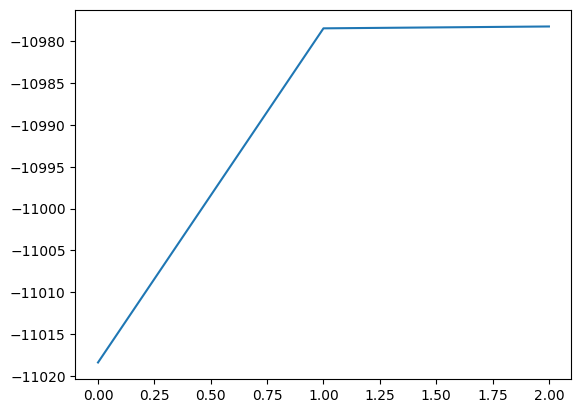

In [326]:
from non_local_detector.core import (
    check_converged,
    chunked_filter_smoother,
)

env = Environment(place_bin_size=2.0).fit_place_grid(position[:, None])
n_position_bins = env.place_bin_centers_.shape[0]
position_index = np.digitize(position, env.place_bin_edges_[:, 0][1:-1])
occupancy_count = np.bincount(
    position_index, minlength=n_position_bins, weights=weights
)

initial_conditions = np.zeros((n_position_bins + 1,))

# State 1 is local - start in local state
# initial_conditions[1:] are the non-local state initial conditions
initial_conditions[0] = 1.0

# Local -> Local, Local -> Non-Local, Non-Local -> Local, Non-Local -> Non-Local
discrete_transition_matrix = np.array(
    [
        [0.999, 1 - 0.999],
        [0.02, 0.98],
    ]
)

continuous_transition_matrix = np.zeros((n_position_bins + 1, n_position_bins + 1))
continuous_transition_matrix[0, 0] = (
    Discrete().make_state_transition()
)  # Local -> Local
continuous_transition_matrix[0, 1:] = (
    np.ones((n_position_bins,)) / n_position_bins
)  # Local -> Non-Local
continuous_transition_matrix[1:, 0] = (
    np.ones((n_position_bins,)) / n_position_bins
)  # Non-local -> Local, consider random walk centered around the current position
continuous_transition_matrix[1:, 1:] = RandomWalk(
    movement_var=6.0
).make_state_transition(
    environments=[env]
)  # Non-Local -> Non-Local
continuous_transition_matrix[
    1:, 1:
] += 1e-15  # Add small value to avoid division by zero
continuous_transition_matrix = continuous_transition_matrix / np.sum(
    continuous_transition_matrix, axis=1, keepdims=True
)  # Normalize

# State 0 is local
state_ind = np.zeros((n_position_bins + 1,), dtype=int)
state_ind[1:] = 1

# Combine the continuous and discrete transition matrices
transition_matrix = (
    continuous_transition_matrix
    * discrete_transition_matrix[np.ix_(state_ind, state_ind)]
)
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)

# Initial conditions
weights = np.ones_like(time)
marginal_likelihoods = []
is_converged = False
iter = 0


while not is_converged and iter < 30:
    log_likelihood, estimated_position_rates = estimate_log_likelihood(
        spike_counts, position_index, occupancy_count, weights
    )

    (
        acausal_posterior,
        acausal_state_probabilities,
        marginal_likelihood,
        causal_state_probabilities,
        predictive_state_probabilities,
        _,
    ) = chunked_filter_smoother(
        time,
        state_ind,
        initial_conditions,
        transition_matrix,
        None,
        None,
        cache_log_likelihoods=False,
        log_likelihoods=log_likelihood,
    )
    weights = acausal_state_probabilities[:, 0]
    initial_conditions = acausal_posterior[0]
    marginal_likelihoods.append(marginal_likelihood)

    try:
        is_converged, is_increasing = check_converged(
            marginal_likelihoods[-1], marginal_likelihoods[-2]
        )
    except IndexError:
        pass

    print(f"Iter: {iter}, Marginal Likelihood: {marginal_likelihoods[-1]}")
    iter += 1

plt.plot(marginal_likelihoods)

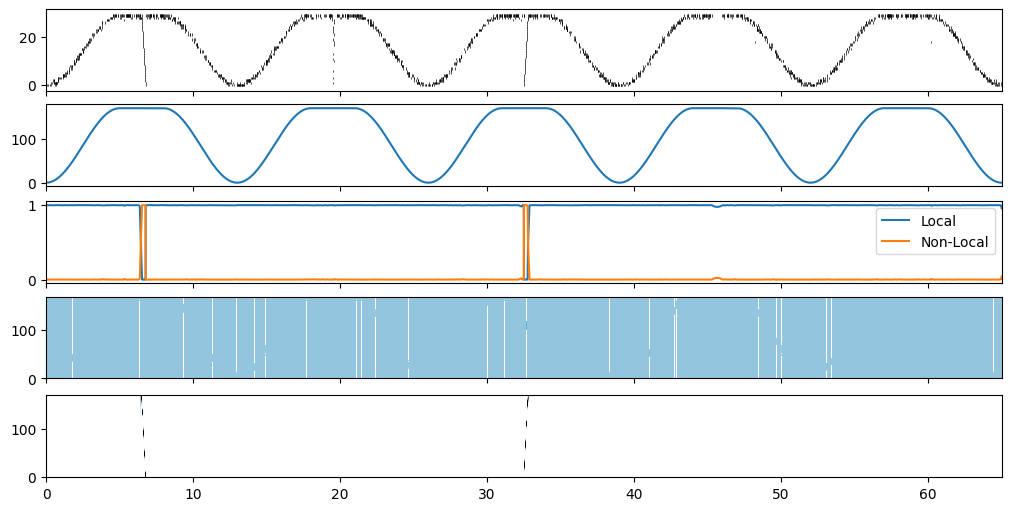

In [327]:
fig, axes = plt.subplots(5, 1, figsize=(10, 5), sharex=True, constrained_layout=True)

axes[0].eventplot(spike_times, colors="k", linewidths=0.5)
axes[1].plot(time, position)
axes[2].plot(time, acausal_state_probabilities[:, 0], label="Local")
axes[2].plot(time, acausal_state_probabilities[:, 1], label="Non-Local")
axes[2].legend()

t, x = np.meshgrid(time, env.place_bin_centers_)
axes[3].pcolormesh(
    t,
    x,
    (log_likelihood[:, [0]] - log_likelihood[:, 1:]).T,
    cmap="RdBu_r",
    rasterized=True,
)
axes[4].pcolormesh(
    t, x, acausal_posterior[:, 1:].T, vmin=0.0, vmax=0.1, rasterized=True, cmap="bone_r"
)

(32.300666666666665, 32.972)

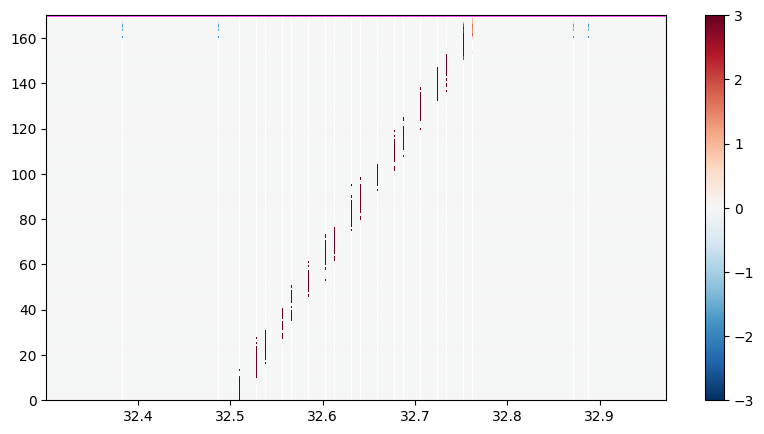

In [287]:
plt.figure(figsize=(10, 5))
plt.pcolormesh(
    t,
    x,
    (log_likelihood[:, 1:] - log_likelihood[:, [0]]).T,
    cmap="RdBu_r",
    rasterized=True,
    vmin=-3,
    vmax=3,
)
plt.plot(time, position, color="magenta", linewidth=2)
plt.colorbar()
plt.xlim(event_times[2] + [-0.200, 0.200])

In [237]:
spike_counts.sum(axis=1)

array([0, 0, 1, ..., 0, 0, 0])

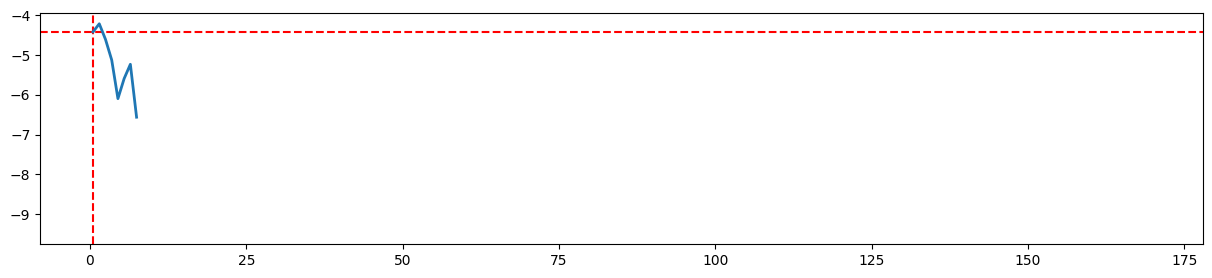

In [269]:
plt.figure(figsize=(15, 3))
plt.axhline(log_likelihood[2, 0], color="r", linestyle="--")
plt.axvline(env.place_bin_centers_[position_index[2]], color="r", linestyle="--")
plt.plot(env.place_bin_centers_, log_likelihood[2, 1:], linewidth=2)

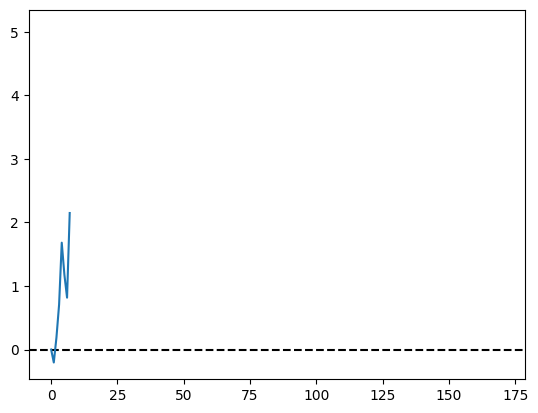

In [270]:
plt.axhline(0, color="k", linestyle="--")
plt.plot(log_likelihood[2, [0]] - log_likelihood[2, 1:])